In [1]:
import math
import librosa
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [29]:
DATA_PATH = '../data/example_data'
RESULTS_PATH = '../data/example_data/real_coeffs/'

COMPUTE_XCORR = False # set to True to compute cross-correlation coefficients

SAMPLING_RATE = 48000
TOTAL_DURATION = 30    # total duration (s)
DISTANCES = np.array([1.24, 2.54, 4.33, 2.88, 4.72, 5.14]) # DISTANCES between sensors AB AC AD BC BD CD or 12 13 14 23 24 34

WIN = 0.2       # duration of segments of sound
HOP = 0.1       # hop duration between successive sound segments
MODE = 'full'   # mode in scipy.signal.fftconvolve. 'same' is faster than 'full' but slightly less accurate
ORDER = 8       # order of Butterworth bandpass filters

THRESHOLD0 = 5*10**-4 # threshold for self-consistency criterion

T = 10 # temperature in degree Celsius

MAX_GAP = 1.    # time threshold for TDoA-based source separation
MAX_DIST = 0.5  # spatial threshold for TDoA-based source separation

MAX_DIST2 = MAX_DIST/4 # maximum between-centroids TDoA-based distance used to group spatially close sources and build sound repertoires


In [15]:
### Calculating cross-correlations between filtered sound segments
if COMPUTE_XCORR :

    size = int(np.round((TOTAL_DURATION - WIN)/HOP,3))
    labels = np.array([1,2,3,4])

    for u in range(-7,0):
        for v in range(u+1,1):
            if v != 0:
                s = scipy.signal.butter(ORDER, [2**u,2**v], btype='bandpass', output='sos')
            else:
                s = scipy.signal.butter(ORDER, 2**u, btype='highpass', output='sos')
            f_res = []
            f_width = []
            for n in range(size) :
                print('layer ' + str(u) + ' ' + str(v) + ' ' + str(n) + ' started')
                f_partial_res = []
                f_partial_widths = []
                for i in range(4) :
                    time = n*HOP
                    delay = time * globals()['slope'+str(i)] + globals()['intercept'+str(i)]
                    globals()['audio_file_' + str(labels[i])] = DATA_PATH + str(labels[i]) + '.wav'
                    globals()['audio_data_' + str(labels[i])] = librosa.load(globals()['audio_file_' + str(labels[i])], sr = SAMPLING_RATE, offset = time + delay, duration = WIN)[0]
                    globals()['f_audio_data_' + str(labels[i])] = scipy.signal.sosfilt(s, globals()['audio_data_' + str(labels[i])])
                for i in range(3):
                    for j in range(i+1,4):
                        f_conv = scipy.signal.fftconvolve(globals()['f_audio_data_' + str(labels[i])], np.flip(globals()['f_audio_data_' + str(labels[j])]), mode = MODE)
                        a_f_conv = scipy.signal.hilbert(f_conv)
                        e_f_conv = np.abs(a_f_conv)
                        peak = np.where(e_f_conv == max(e_f_conv))[0][0]
                        if len(np.where(e_f_conv[range(peak, len(e_f_conv))] < e_f_conv[peak]/2)[0]) > 0 and len(np.where(e_f_conv[range(peak)] < e_f_conv[peak]/2)[0]) > 0 :
                            f_partial_width = (peak + min(np.where(e_f_conv[range(peak, len(e_f_conv))] < e_f_conv[peak]/2)[0]) - max(np.where(e_f_conv[range(peak)] < e_f_conv[peak]/2)[0]))/SAMPLING_RATE
                        else :
                            f_partial_width = 0
                        f_partial_res.append(((int((len(e_f_conv)-(MODE=='full'))/2) - np.where(e_f_conv == max(e_f_conv))[0])/SAMPLING_RATE)[0])
                        f_partial_widths.append(f_partial_width)
                f_res.append(list(f_partial_res))
                f_width.append(list(f_partial_widths))
            globals()['f_res_'   + str(-u) + '_' + str(-v)] = f_res
            globals()['f_width_' + str(-u) + '_' + str(-v)] = f_width
            np.save(RESULTS_PATH +'res'     + str(u) + '_' + str(v), f_res)
            np.save(RESULTS_PATH +'width'   + str(u) + '_' + str(v), f_width)
            print('layer ' + str(u) + ' ' + str(v) + ' performed')

In [30]:
### Applying self-consistency criterion (with THRESHOLD0 parameter)

# xs stores the result of pairwise self-consistent cross-correlations, peak_widths measures their imprecision
# us and vs give critical frequencies of filtering ((SAMPLING_RATE/2)*2**u and (SAMPLING_RATE/2)*2**v), hs*HOP the corresponding timings

xs, peak_widths = np.empty((0,6)), np.empty((0,6))
us, vs, hs = np.empty(0), np.empty(0), np.empty(0)

for u in range(-7,0) :
    for v in range(u+1,1):
        f_res   = np.load(RESULTS_PATH +'res'   + str(u) + '_' + str(v) + '.npy')
        f_width = np.load(RESULTS_PATH +'width' + str(u) + '_' + str(v) + '.npy')
        tot = np.array([f_res[:,0]+f_res[:,3]-f_res[:,1], f_res[:,0]+f_res[:,4]-f_res[:,2], f_res[:,1]+f_res[:,5]-f_res[:,2], f_res[:,3]+f_res[:,5]-f_res[:,4]])
        h = np.where(np.sum(abs(tot) < THRESHOLD0, axis = 0) == 4)[0] # select sound segments verifying self-consistency criterion
        us = np.append(us, np.repeat(u, len(h)))
        vs = np.append(vs, np.repeat(v, len(h)))
        hs = np.append(hs, h)
        xs = np.concatenate((xs, f_res[h]), axis = 0)
        peak_widths = np.concatenate((peak_widths, f_width[h]), axis = 0)

permutation = np.argsort(hs) # rearranging data over time
sorted_us = us[permutation]
sorted_vs = vs[permutation]
sorted_hs = hs[permutation]
sorted_xs = xs[permutation]
sorted_peak_widths = peak_widths[permutation]

In [31]:
# TDoA-based source separation (using time threshold MAX_GAP and TDoA-based distance threshold MAX_DIST)

cair= 331.5*math.sqrt(1+T/273.15) # sound speed

def dist (p,q): # TDoA-based distance between sound segments
    return(math.sqrt(np.sum((sorted_xs[p] - sorted_xs[q])**2))*cair)

row = []
col = []
gap = int(np.round(MAX_GAP/HOP))
for i in range(len(sorted_hs)) :
    m = max(0,i-28*gap)
    for j in np.where(abs(sorted_hs[m:i] - sorted_hs[i]) <= gap)[0] :
        if dist(i, j+m) < MAX_DIST :
            row.append(j+m)
            col.append(i)

# Each source corresponds to one of the n_components connected components of graph (stored in connects variable)
graph = scipy.sparse.csr_matrix((np.ones(len(row)), (np.array(row),np.array(col))), shape=(len(sorted_hs),len(sorted_hs))) # compute sparse csr matrix to avoid huge data
n_components, connects = scipy.sparse.csgraph.connected_components(csgraph=graph, directed=False, return_labels=True)


In [34]:
### Removing marginal sources

# no sound source removal
filter0 = np.arange(n_components)
# remove sound sources associated with a single self-consistent frequency-time segment
filter1 = np.where(np.array([len(np.where(connects==i)[0]) for i in range(n_components)])>1)[0]
# remove sound sources associated with a single self-consistent time segment, potentially present in differently filtered forms
filter2 = np.where(np.array([np.max(sorted_hs[np.where(connects==i)] - np.min(sorted_hs[np.where(connects==i)])) for i in range(n_components)])<1)[0]

# choose a method from those above :
filt = filter1

filt_n_components = len(filt)
ind = np.where([any(filt == i) for i in connects])[0]
filt_sorted_hs = sorted_hs[ind]
filt_sorted_us = sorted_us[ind]
filt_sorted_vs = sorted_vs[ind]
filt_sorted_xs = sorted_xs[ind]
filt_connects = scipy.stats.rankdata(connects[ind], method = 'dense')-1

In [35]:
### Construction of sound repertoires associated with locations (with MAX_DIST2 threshold)

barycenters = np.array([np.mean(filt_sorted_xs[np.where(filt_connects==i)],0) for i in range(filt_n_components)])*cair
centers_dist_matrix = scipy.spatial.distance_matrix(barycenters, barycenters)
n_components2, connects2 = scipy.sparse.csgraph.connected_components(centers_dist_matrix < MAX_DIST2)
ranking = np.argsort([len(np.where(connects2==i)[0]) for i in range(n_components2)])[::-1]

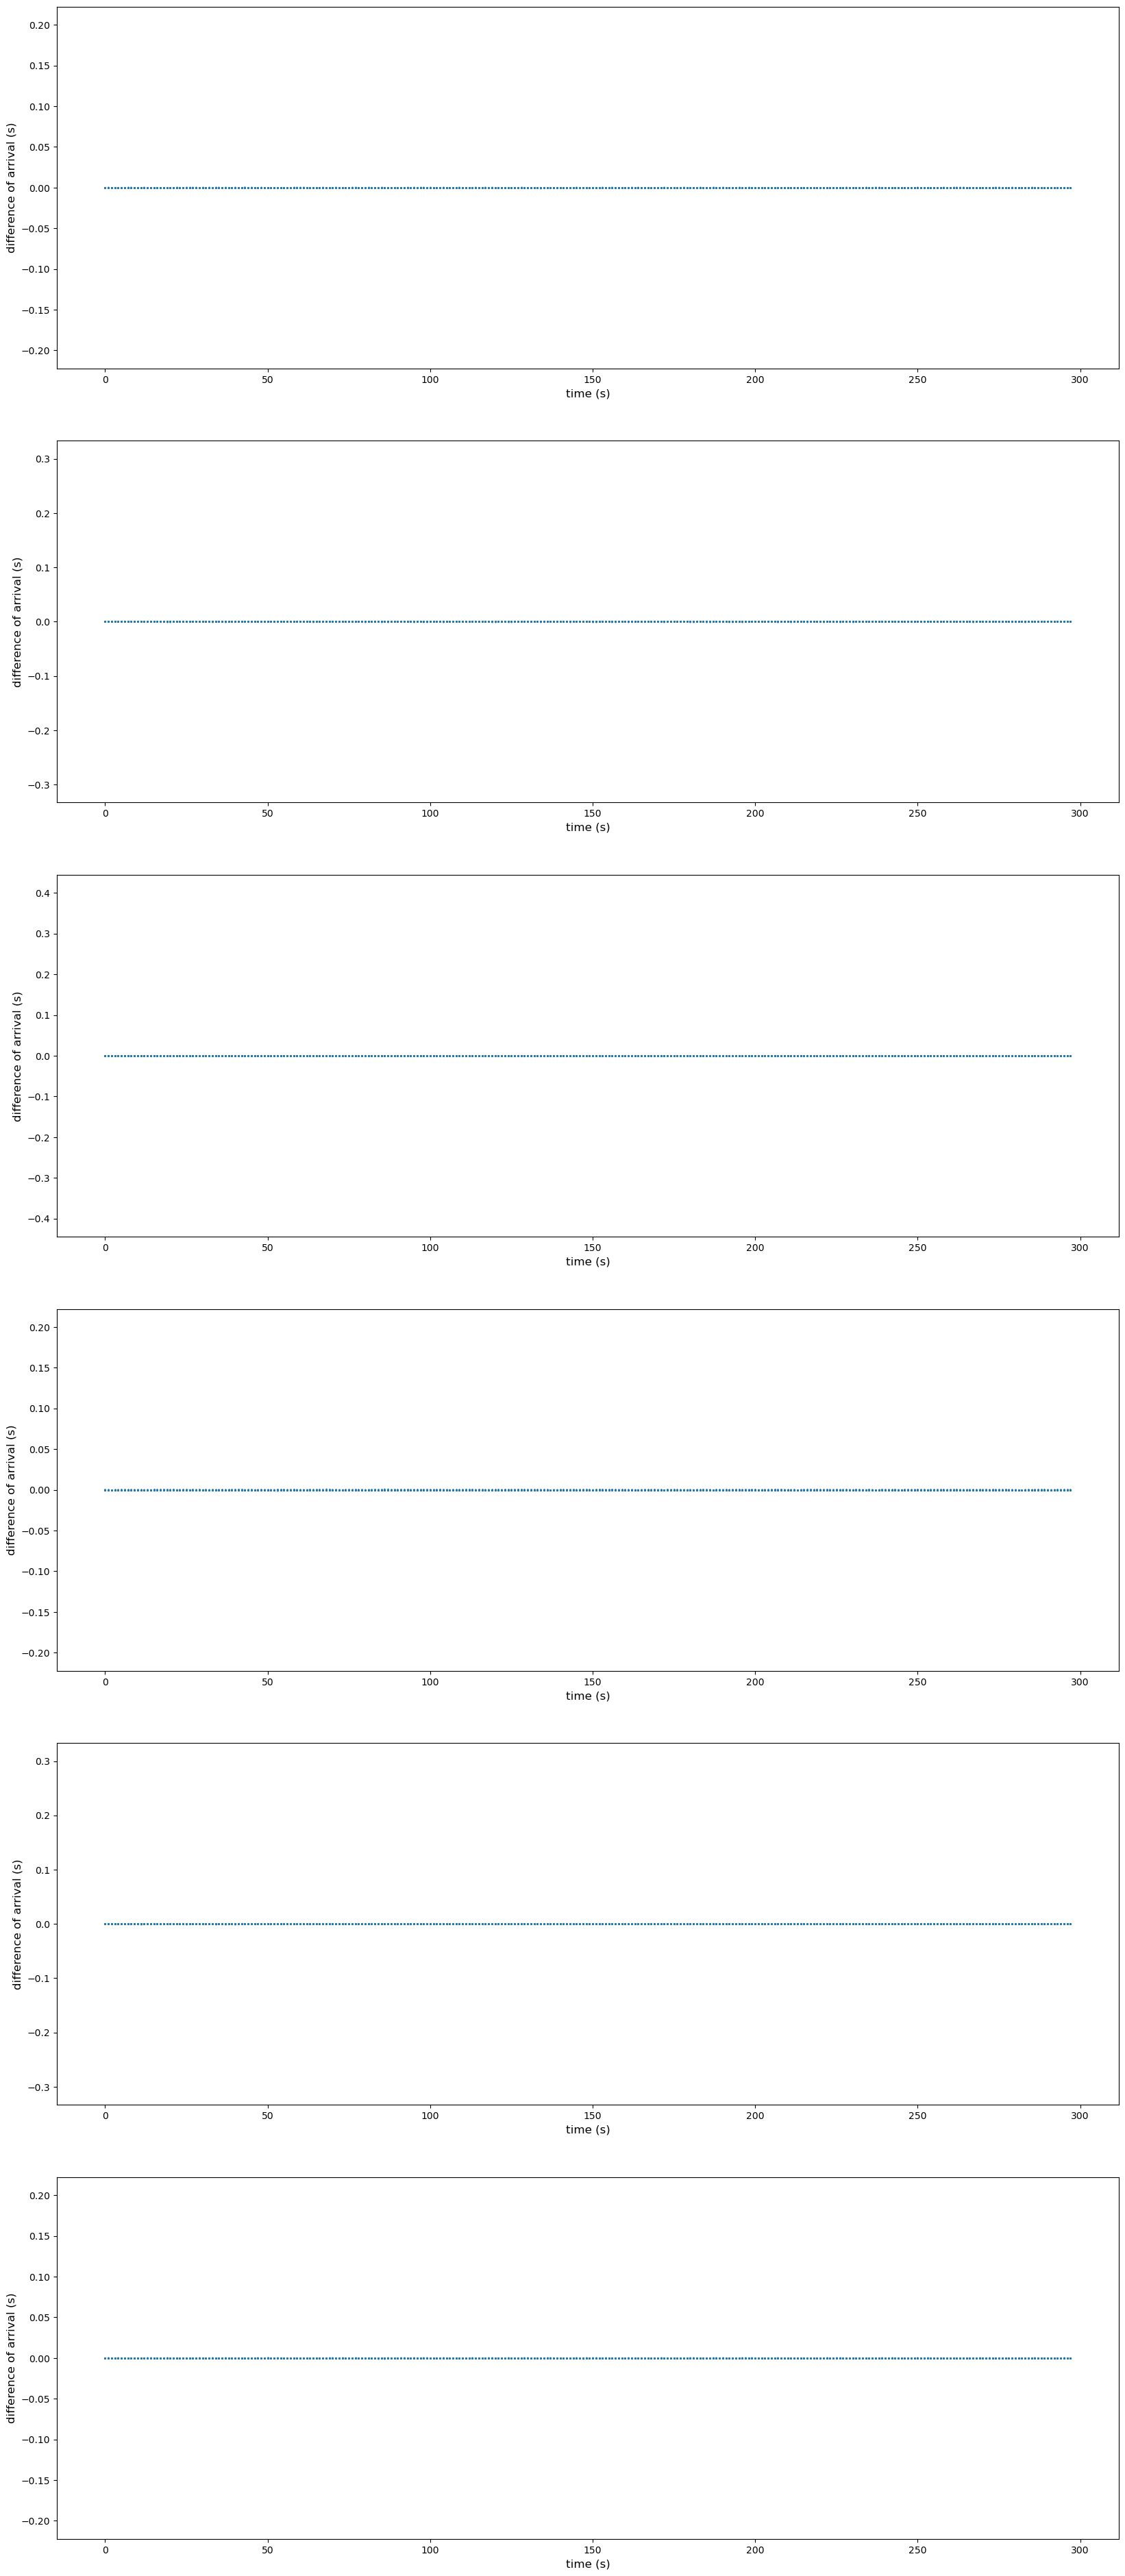

In [36]:
### Plotting temporal organization of soundscape

fig, ax = plt.subplots(6,1,figsize = (20,48))

# couleurs2 = np.load(RESULTS_PATH+'couleurs2.npy')
lim_factor = 1.5

ylim0 = (-DISTANCES[0]*lim_factor/cair, DISTANCES[0]*lim_factor/cair)
ylim1 = (-DISTANCES[1]*lim_factor/cair, DISTANCES[1]*lim_factor/cair)
ylim2 = (-DISTANCES[2]*lim_factor/cair, DISTANCES[2]*lim_factor/cair)
ylim3 = (-DISTANCES[3]*lim_factor/cair, DISTANCES[3]*lim_factor/cair)
ylim4 = (-DISTANCES[4]*lim_factor/cair, DISTANCES[4]*lim_factor/cair)
ylim5 = (-DISTANCES[5]*lim_factor/cair, DISTANCES[5]*lim_factor/cair)

ax[0].set_ylim(ylim0)
ax[1].set_ylim(ylim1)
ax[2].set_ylim(ylim2)
ax[3].set_ylim(ylim3)
ax[4].set_ylim(ylim4)
ax[5].set_ylim(ylim5)

ax[0].scatter(filt_sorted_hs, filt_sorted_xs[:,0], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)
ax[1].scatter(filt_sorted_hs, filt_sorted_xs[:,1], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)
ax[2].scatter(filt_sorted_hs, filt_sorted_xs[:,2], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)
ax[3].scatter(filt_sorted_hs, filt_sorted_xs[:,3], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)
ax[4].scatter(filt_sorted_hs, filt_sorted_xs[:,4], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)
ax[5].scatter(filt_sorted_hs, filt_sorted_xs[:,5], c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.2)

for i in range(6):
    ax[i].set_xlabel('time (s)', size = 12)
    ax[i].set_ylabel('difference of arrival (s)', size = 12)

In [12]:
# Getting Cartesian positions

AB = DISTANCES[0]
AC = DISTANCES[1]
AD = DISTANCES[2]
BC = DISTANCES[3]
BD = DISTANCES[4]
CD = DISTANCES[5]

xA = 0
yA = 0
zA = 0
xB = AB
yB = 0
zB = 0
xC = (AC**2 - BC**2 + xB**2)/(2*xB)
yC = math.sqrt(AC**2 - xC**2)
zC = 0
xD = (AD**2 - BD**2 + xB**2)/(2*xB)
yD = (AD**2 - CD**2 + xC**2 + yC**2 - 2*xC*xD)/(2*yC)
zD = math.sqrt(AD**2 - xD**2 - yD**2)

x0 = [xA, xB, xC, xD]
y0 = [yA, yB, yC, yD]
z0 = [zA, zB, zC, zD] 

M = np.array([[xB, yB, zB], [xC, yC, zC], [xD, yD, zD]])
Minv = np.linalg.inv(M)

u2 = np.vstack([filt_sorted_xs[:,0], filt_sorted_xs[:,1], filt_sorted_xs[:,2]])*cair
u1 = [(AB**2 - u2[0]**2)/2, (AC**2 - u2[1]**2)/2, (AD**2 - u2[2]**2)/2]
v1 = Minv.dot(u1)
v2 = Minv.dot(u2)
delta_prime = [(v1[:,i].dot(v2[:,i]))**2 - (v2[:,i].dot(v2[:,i])-1)*v1[:,i].dot(v1[:,i]) for i in range(len(v1[0]))]
AS1 = [(v1[:,i].dot(v2[:,i]) + np.sqrt(delta_prime[i]))/(v2[:,i].dot(v2[:,i])-1) for i in range(len(v1[0]))]
AS2 = [(v1[:,i].dot(v2[:,i]) - np.sqrt(delta_prime[i]))/(v2[:,i].dot(v2[:,i])-1) for i in range(len(v1[0]))]
xyz1 = (v1 - AS1*v2)*np.sign(np.sqrt(AS1)) # last factor was put to eliminate negative distances to source
xyz2 = (v1 - AS2*v2)*np.sign(np.sqrt(AS2)) # last factor was put to eliminate negative distances to source


/tmp/ipykernel_687019/3812558779.py:37: RuntimeWarning: invalid value encountered in sqrt
  xyz1 = (v1 - AS1*v2)*np.sign(np.sqrt(AS1)) # last factor was put to eliminate negative distances to source


AttributeError: 'XTick' object has no attribute 'label'

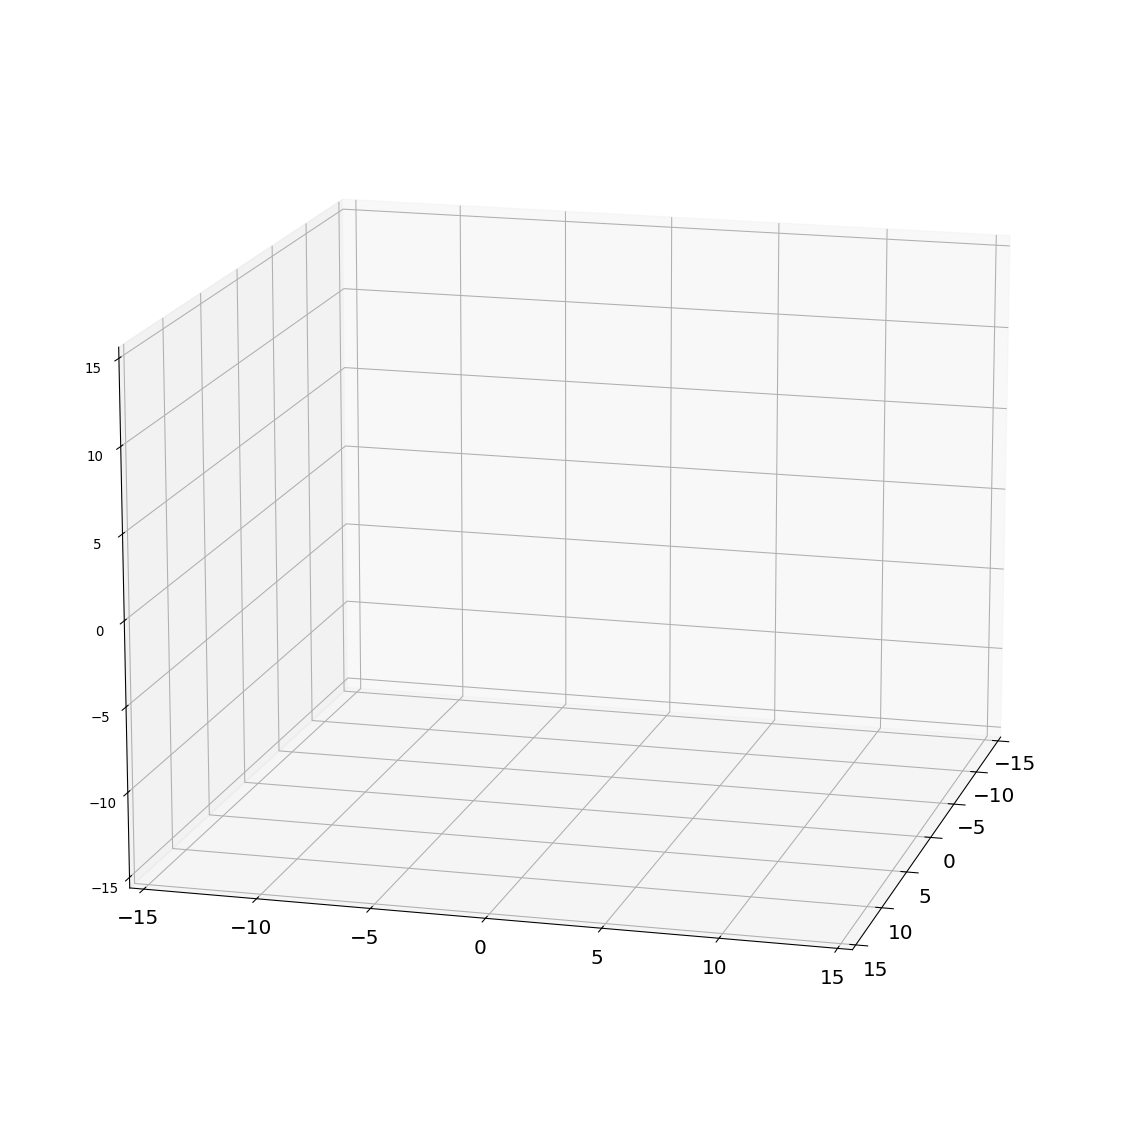

In [13]:
### Plotting spatial organization of soundscape (Cartesian)

fig = plt.figure(figsize = (15,20), dpi = 96)
ax3d = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(hspace = 10, wspace = 10)

ax3d.view_init(15,15)

ax3d.set_xlim([-15,15])
ax3d.set_ylim([-15,15])
ax3d.set_zlim([-15,15])

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for t in ax3d.zaxis.get_major_ticks(): 
    t.label.set_size(15)

ax3d.text(8, -13.5, -15, 'x (meters)', 'x', size = 20)
ax3d.text(15, -2, -15, 'y (meters)', (0,0.27,0), size = 20)
ax3d.text(15, -15, -1.5, 'z (meters)', (0,0,-1), size = 20)

ax3d.scatter(xyz1[2], xyz1[1], xyz1[0], c = np.concatenate((np.array([couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))]), np.resize(1 - 0.8*(1 - np.isnan(xyz1[1]))*(1 - np.isnan(xyz2[1])), (len(xyz1[1]),1))), axis = 1), s = 0.1)
ax3d.scatter(xyz2[2], xyz2[1], xyz2[0], c = np.concatenate((np.array([couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))]), np.resize(1 - 0.8*(1 - np.isnan(xyz1[1]))*(1 - np.isnan(xyz2[1])), (len(xyz1[1]),1))), axis = 1), s = 0.1)

ax3d.plot([z0[0],z0[1]], [y0[0],y0[1]], [x0[0],x0[1]], c = 'black') 
ax3d.plot([z0[0],z0[2]], [y0[0],y0[2]], [x0[0],x0[2]], c = 'black') 
ax3d.plot([z0[0],z0[3]], [y0[0],y0[3]], [x0[0],x0[3]], c = 'black') 
ax3d.plot([z0[1],z0[2]], [y0[1],y0[2]], [x0[1],x0[2]], c = 'black') 
ax3d.plot([z0[1],z0[3]], [y0[1],y0[3]], [x0[1],x0[3]], c = 'black') 
ax3d.plot([z0[2],z0[3]], [y0[2],y0[3]], [x0[2],x0[3]], c = 'black')

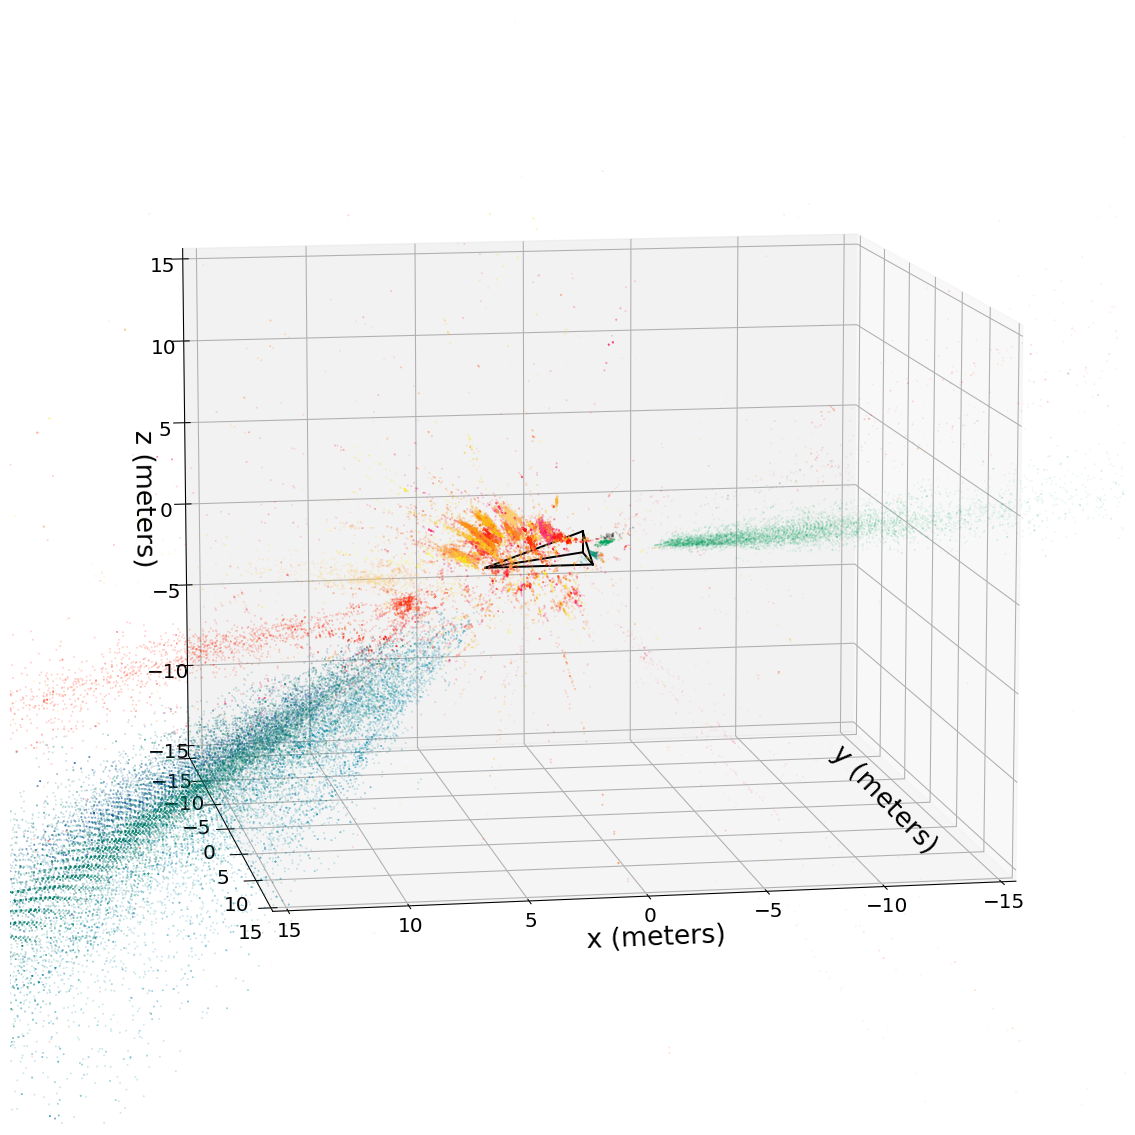

In [9]:
### Plotting spatial organization of soundscape (Cartesian)

fig = plt.figure(figsize = (15,20), dpi = 96)

ax3d = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(hspace = 10, wspace = 10)
ax3d.view_init(10,80)

ax3d.set_xlim([-15,15])
ax3d.set_ylim([-15,15])
ax3d.set_zlim([-15,15])

ax3d.tick_params(axis='x', pad=-1.5)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for t in ax3d.zaxis.get_major_ticks(): 
    t.label.set_size(15)

ax3d.set_xlabel('x (meters)', size = 20)
ax3d.text(-12, -5, -20, 'y (meters)', (0,0.27,0), size = 20)
ax3d.set_zlabel('z (meters)', size = 20)

ax3d.scatter(xyz1[2], xyz1[1], xyz1[0], c = np.concatenate((np.array([couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))]), np.resize(1 - 0.8*(1 - np.isnan(xyz1[1]))*(1 - np.isnan(xyz2[1])), (len(xyz1[1]),1))), axis = 1), s = 0.1)
ax3d.scatter(xyz2[2], xyz2[1], xyz2[0], c = np.concatenate((np.array([couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))]), np.resize(1 - 1*(1 - np.isnan(xyz1[1]))*(1 - np.isnan(xyz2[1])), (len(xyz1[1]),1))), axis = 1), s = 0.1)
ax3d.plot([z0[0],z0[1]], [y0[0],y0[1]], [x0[0],x0[1]], c = 'black') 
ax3d.plot([z0[0],z0[2]], [y0[0],y0[2]], [x0[0],x0[2]], c = 'black') 
ax3d.plot([z0[0],z0[3]], [y0[0],y0[3]], [x0[0],x0[3]], c = 'black') 
ax3d.plot([z0[1],z0[2]], [y0[1],y0[2]], [x0[1],x0[2]], c = 'black') 
ax3d.plot([z0[1],z0[3]], [y0[1],y0[3]], [x0[1],x0[3]], c = 'black') 
ax3d.plot([z0[2],z0[3]], [y0[2],y0[3]], [x0[2],x0[3]], c = 'black') 

Text(0, 0.5, 'Elevation (degree)')

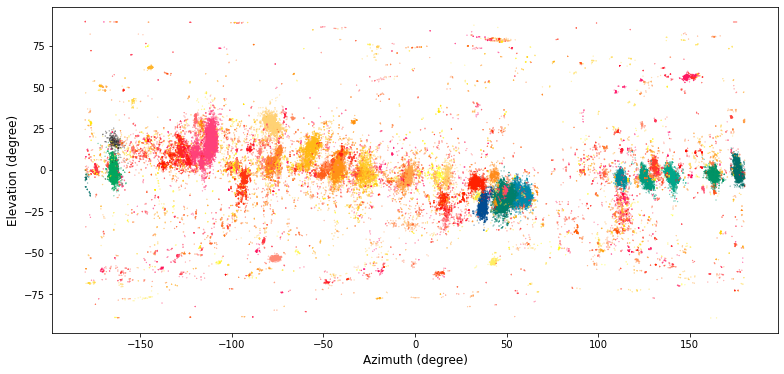

In [10]:
### Plotting spatial organization of soundscape (direction of arrival)

fig, ax = plt.subplots(1,1,figsize = (13,6))

indices1 = [0,1,2]
indices2 = [1,2,3]
xyz3 = np.linalg.inv(np.array([[0, 1.24, 0, 0],[0, 0, 2.5370169737055224, 0],[0, 0, 0, 4.245683403576646]])[:,indices2]).dot(np.transpose(filt_sorted_xs[:,indices1]*cair))

r = np.sqrt(np.sum(xyz3**2, axis = 0))
theta = np.arccos(xyz3[0]/r) - math.pi/2
phi = (np.arctan2(-xyz3[1],-xyz3[2]))
plt.scatter(phi*180/math.pi, theta*180/math.pi, c = [couleurs2[:, connects2[filt_connects[i]]] for i in range(len(filt_connects))], s = 0.05)

plt.xlabel('Azimuth (degree)', size = 12)
plt.ylabel('Elevation (degree)', size = 12)


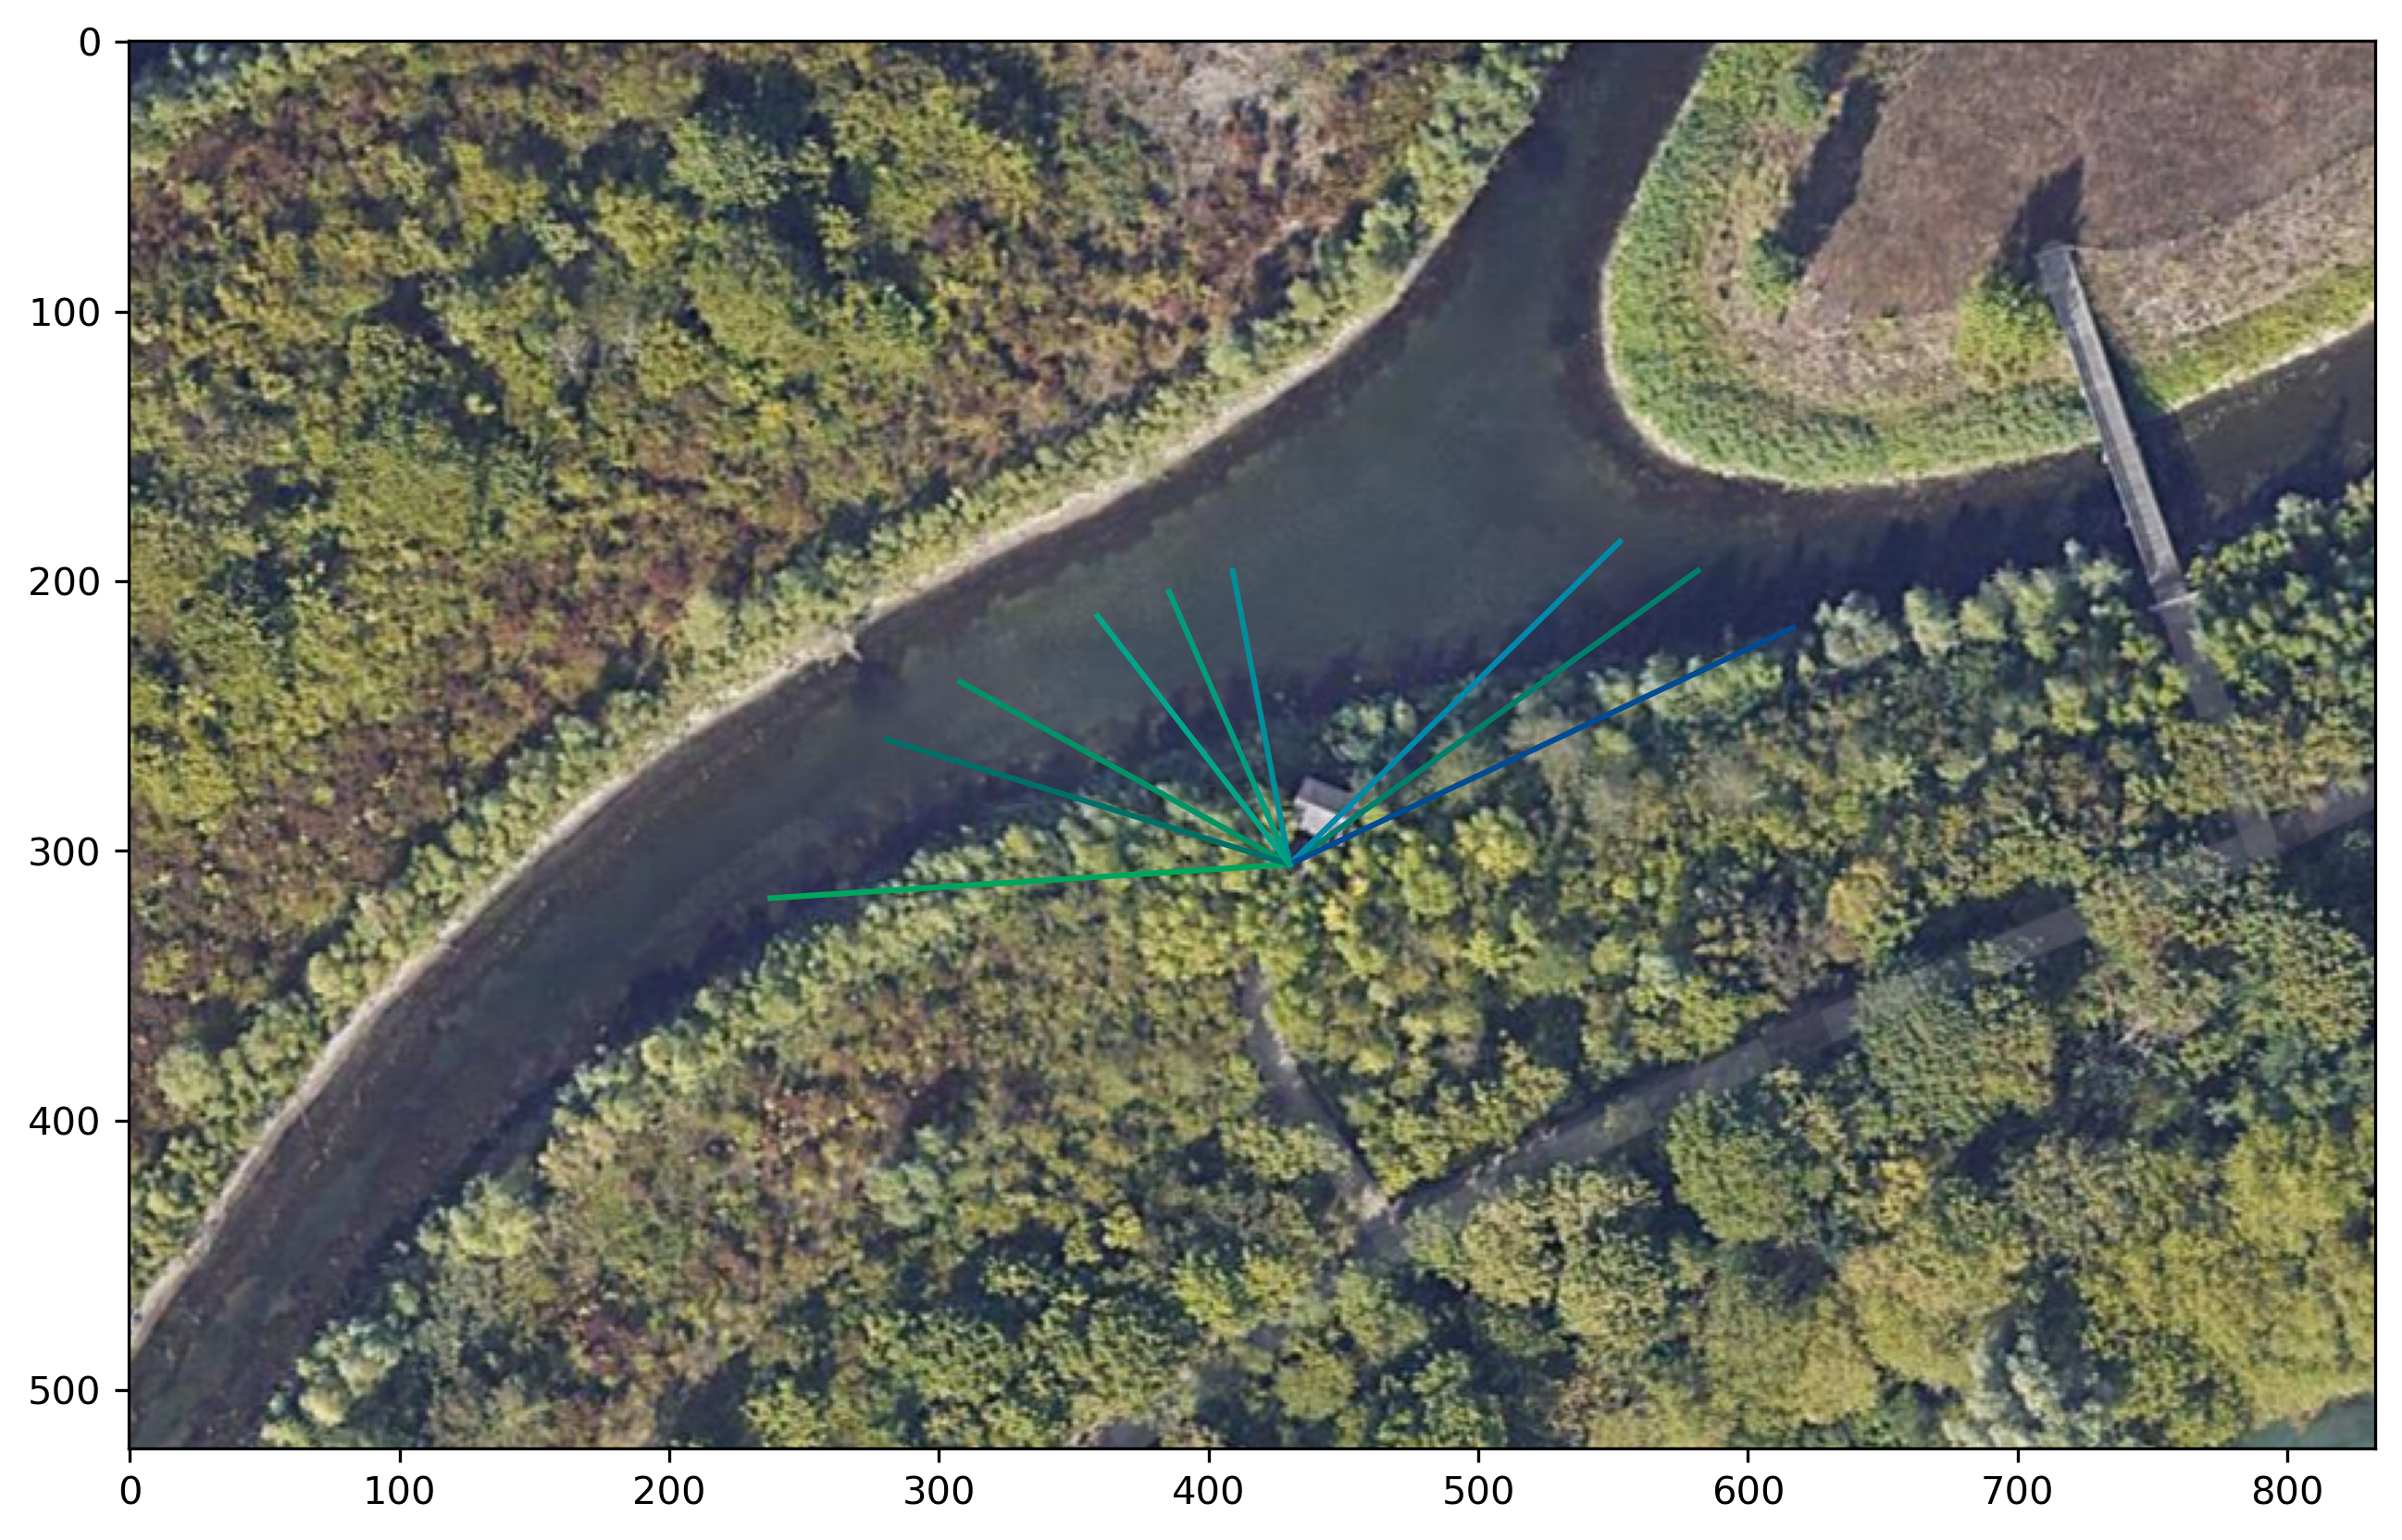

In [11]:
# Plotting angular positions of micro-sites occupied by amphibians

fig = plt.figure(figsize = (10.44,16.66), dpi = 300)

img = plt.imread('C:/Users/Laurent/Desktop/Polytope de la Haute-Île/position angulaire des sources amphibiennes.png')

amphibian_indices = [5,0,3,22,9,147,24,1,247] # got from aural identification
center = [430, 305]
radius_0 = 200
angle_0 = -12
angles = np.array([np.nanmean(phi[np.where(connects2[filt_connects] == i)])*180/math.pi for i in amphibian_indices])
alpha = 0.5
radiuses = [220*(1-alpha*math.sin((-30+angles[i])*math.pi/180)) for i in range(len(amphibian_indices))]
for i in range(len(amphibian_indices)) :
    plt.plot([center[0], center[0]+radiuses[i]*math.cos(-(angle_0+angles[i])*math.pi/180)], [center[1], center[1]+radiuses[i]*math.sin(-(angle_0+angles[i])*math.pi/180)], color = couleurs2[:,amphibian_indices[i]], linewidth = 1.5)

imgplot = plt.imshow(img)